Linear Regression CV R2 scores: [0.58601791 0.58020519 0.67019037 0.72394485 0.76381348]
Linear Regression Test R2: 0.6931617756824213
Polynomial Regression CV R2 scores: [0.58894921 0.26131572 0.56491437 0.1211856  0.76343602]
Polynomial Regression Test R2: 0.5926646685152094
SVR CV R2 scores: [0.63893027 0.52726426 0.45722051 0.25614415 0.20698768]
SVR Test R2: 0.5452195785246685
Random Forest CV R2 scores: [0.75529624 0.68004237 0.84877393 0.79212228 0.72145886]
Random Forest Test R2: 0.7752479216090171


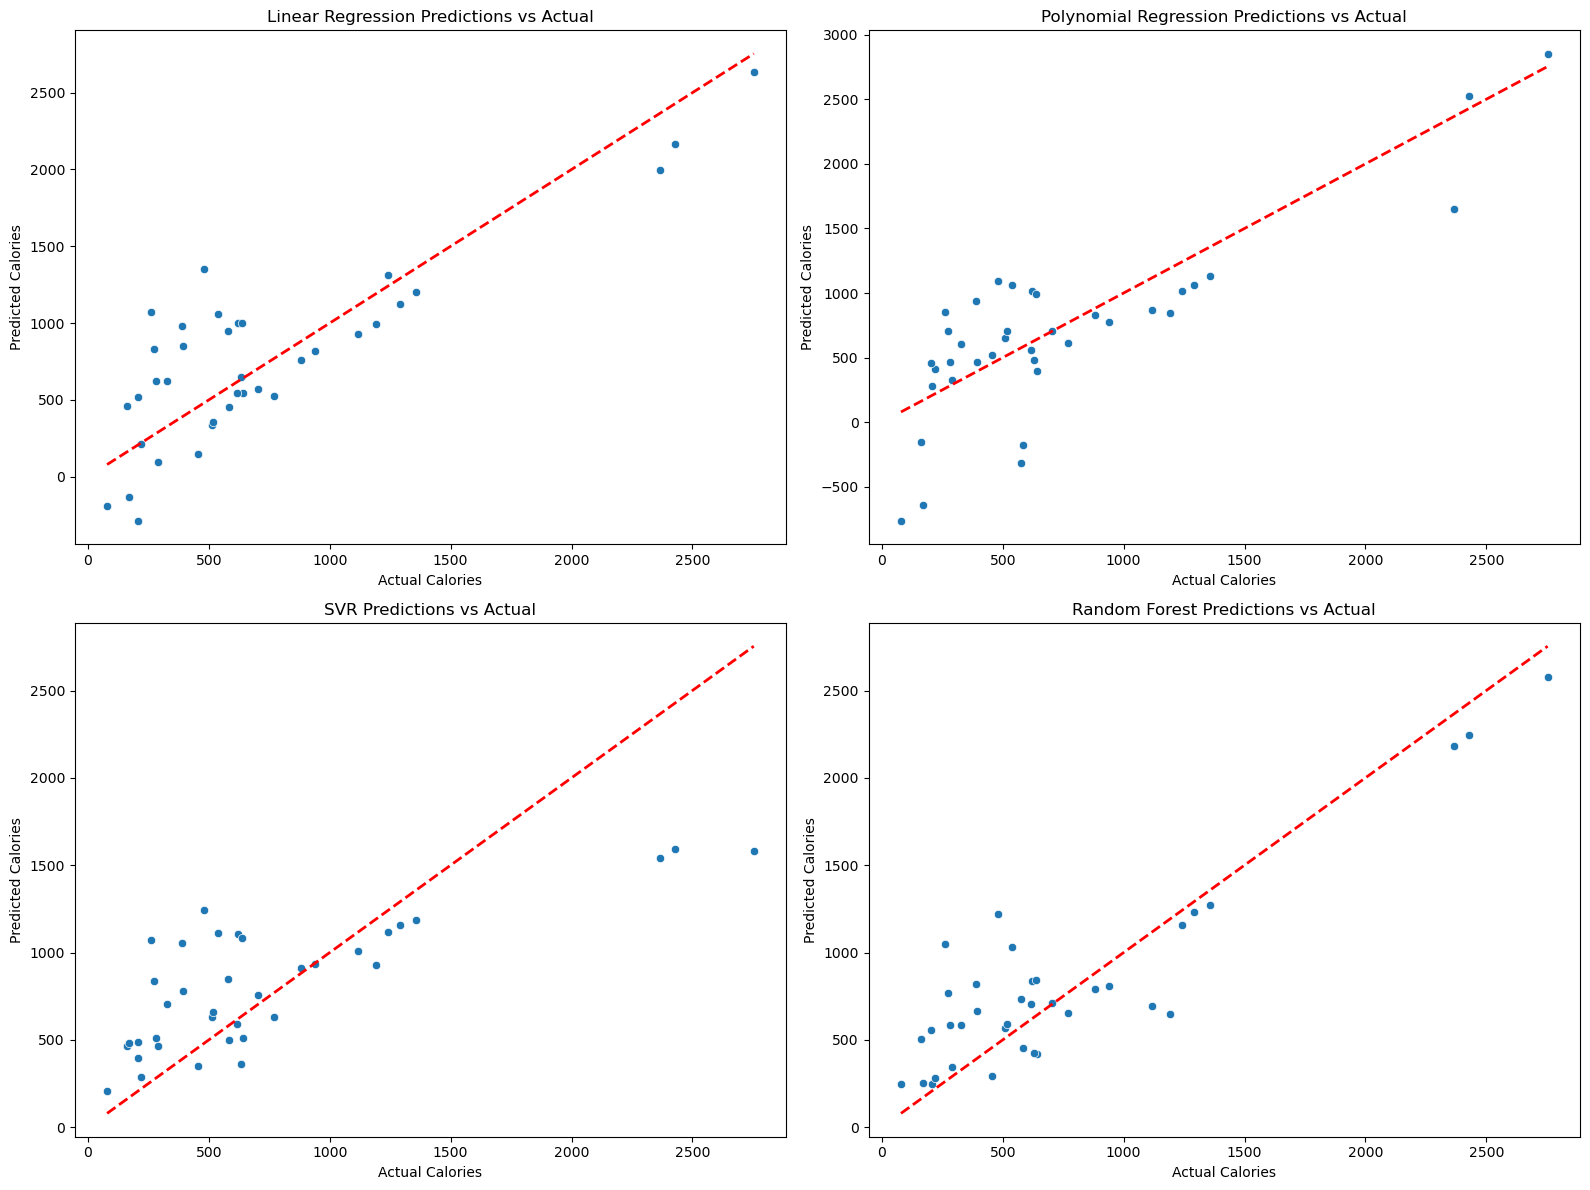

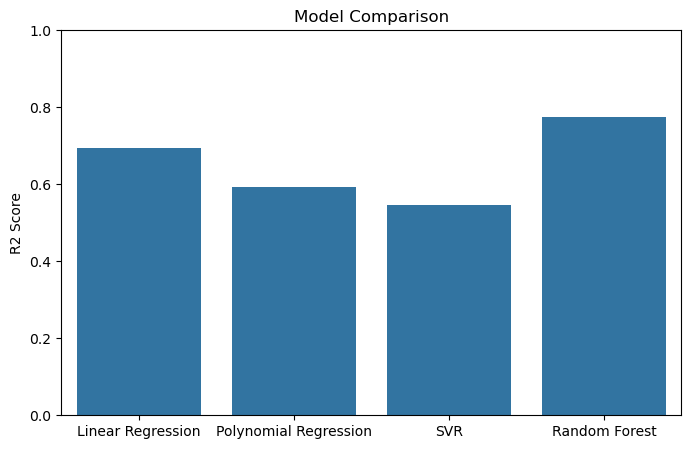

In [13]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer

# Load dataset
df = pd.read_csv("extended_activities_with_ftp.csv")

# --- Feature Engineering ---
df['speed_to_power_ratio'] = df['Average Speed'] / (df['Average Watts'] + 1e-6)
df['altitude_gain_per_km'] = df['Elevation Gain'] / (df['Distance'] + 1e-6)

# Define features (X) and target (y)
X = df[['Distance', 'Average Watts', 'Average Speed', 'Elevation Gain', 
        'speed_to_power_ratio', 'altitude_gain_per_km']]
y = df['Calories']

# --- Handle missing values ---
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Linear Regression ---
lin_reg = LinearRegression()
lin_scores = cross_val_score(lin_reg, X_train, y_train, cv=kf, scoring='r2')
print("Linear Regression CV R2 scores:", lin_scores)
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
print("Linear Regression Test R2:", r2_score(y_test, y_pred_lin))

# --- Polynomial Regression ---
poly_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lin_reg', LinearRegression())
])
poly_scores = cross_val_score(poly_pipeline, X_train, y_train, cv=kf, scoring='r2')
print("Polynomial Regression CV R2 scores:", poly_scores)
poly_pipeline.fit(X_train, y_train)
y_pred_poly = poly_pipeline.predict(X_test)
print("Polynomial Regression Test R2:", r2_score(y_test, y_pred_poly))

# --- Support Vector Regression (SVR) ---
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1))
])
svr_scores = cross_val_score(svr_pipeline, X_train, y_train, cv=kf, scoring='r2')
print("SVR CV R2 scores:", svr_scores)
svr_pipeline.fit(X_train, y_train)
y_pred_svr = svr_pipeline.predict(X_test)
print("SVR Test R2:", r2_score(y_test, y_pred_svr))

# --- Random Forest Regression ---
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_scores = cross_val_score(rf_reg, X_train, y_train, cv=kf, scoring='r2')
print("Random Forest CV R2 scores:", rf_scores)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)
print("Random Forest Test R2:", r2_score(y_test, y_pred_rf))

# --- Plot Predictions vs Actual ---
models = {
    'Linear Regression': y_pred_lin,
    'Polynomial Regression': y_pred_poly,
    'SVR': y_pred_svr,
    'Random Forest': y_pred_rf
}

plt.figure(figsize=(16, 12))
for i, (name, y_pred) in enumerate(models.items(), 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Calories')
    plt.ylabel('Predicted Calories')
    plt.title(f'{name} Predictions vs Actual')

plt.tight_layout()
plt.show()

# --- Optional: Compare R2 Scores ---
r2_scores = {name: r2_score(y_test, y_pred) for name, y_pred in models.items()}
plt.figure(figsize=(8,5))
sns.barplot(x=list(r2_scores.keys()), y=list(r2_scores.values()))
plt.ylabel("R2 Score")
plt.title("Model Comparison")
plt.ylim(0, 1)
plt.show()
